In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [3]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [7]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [8]:
file_import = drive.CreateFile({'id':'15j1Nou6m5WNLejJQrUcty6U03xsIgIAI'})
file_import.GetContentFile('SelfAttention.py') 

from SelfAttention import SelfAttention

In [9]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [10]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [11]:
def single_category_regressor(features, unitsNumber = 68):
    dense_1 = Dense(unitsNumber, activation = 'elu')(features)
    dense_1_normalization = BatchNormalization()(dense_1)
    dense_1_dropout = Dropout(0.2)(dense_1_normalization)

    dense_2 = Dense(unitsNumber, activation = 'elu')(dense_1_dropout)
    dense_2_normalization = BatchNormalization()(dense_2)
    dense_2_dropout = Dropout(0.2)(dense_2_normalization)
    
    return Dense(1, activation='sigmoid')(dense_2_dropout)

In [12]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

embedding_dropout = SelfAttention()(embedding_dropout)

features_1 = one_by_one(filtersNumber, embedding_dropout)
features_2 = one_by_one(filtersNumber, features_1)
features_3 = one_by_one(filtersNumber, features_2)

features = yoon_kim_feature_extractor(filtersNumber, features_3)

output_layer = concatenate([
    single_category_regressor(features, 128),
    single_category_regressor(features, 128),
    single_category_regressor(features, 128),
    single_category_regressor(features, 128),
    single_category_regressor(features, 128),
    single_category_regressor(features, 128),
])

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21376/102124 [=====>........................] - ETA: 7:50 - loss: 0.1833 - acc: 0.9383

102112/102124 [============================>.] - ETA: 0s - loss: 0.0925 - acc: 0.9685

102124/102124 [==============================] - 606s 6ms/step - loss: 0.0925 - acc: 0.9685 - val_loss: 0.0943 - val_acc: 0.9750
Epoch 2/32
 14048/102124 [===>..........................] - ETA: 8:04 - loss: 0.0596 - acc: 0.9785

102112/102124 [============================>.] - ETA: 0s - loss: 0.0573 - acc: 0.9789

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0573 - acc: 0.9789 - val_loss: 0.0525 - val_acc: 0.9812
roc-auc: 0.9836 - roc-auc_val: 0.9792                                                                                                    
Epoch 3/32
  8736/102124 [=>............................] - ETA: 8:33 - loss: 0.0546 - acc: 0.9796

102112/102124 [============================>.] - ETA: 0s - loss: 0.0533 - acc: 0.9802

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0533 - acc: 0.9802 - val_loss: 0.1477 - val_acc: 0.9654
Epoch 4/32
 14048/102124 [===>..........................] - ETA: 8:04 - loss: 0.0505 - acc: 0.9812

102112/102124 [============================>.] - ETA: 0s - loss: 0.0506 - acc: 0.9810

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0506 - acc: 0.9810 - val_loss: 0.0441 - val_acc: 0.9836
roc-auc: 0.9873 - roc-auc_val: 0.9845                                                                                                    
Epoch 5/32
  8736/102124 [=>............................] - ETA: 8:33 - loss: 0.0475 - acc: 0.9822

102112/102124 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.9816

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0487 - acc: 0.9816 - val_loss: 0.0436 - val_acc: 0.9829
Epoch 6/32
 14048/102124 [===>..........................] - ETA: 8:04 - loss: 0.0477 - acc: 0.9823

102112/102124 [============================>.] - ETA: 0s - loss: 0.0471 - acc: 0.9820

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0470 - acc: 0.9820 - val_loss: 0.0414 - val_acc: 0.9840
roc-auc: 0.99 - roc-auc_val: 0.986                                                                                                    
Epoch 7/32
  8800/102124 [=>............................] - ETA: 8:32 - loss: 0.0458 - acc: 0.9826

102112/102124 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.9824

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0457 - acc: 0.9824 - val_loss: 0.0433 - val_acc: 0.9836
Epoch 8/32
 14048/102124 [===>..........................] - ETA: 8:03 - loss: 0.0455 - acc: 0.9816

102112/102124 [============================>.] - ETA: 0s - loss: 0.0449 - acc: 0.9827

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0449 - acc: 0.9827 - val_loss: 0.0414 - val_acc: 0.9841

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00024148408556357026.
roc-auc: 0.9903 - roc-auc_val: 0.9867                                                                                                    
Epoch 9/32
  5952/102124 [>.............................] - ETA: 8:48 - loss: 0.0439 - acc: 0.9824

102112/102124 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9829

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0438 - acc: 0.9829 - val_loss: 0.0413 - val_acc: 0.9840
Epoch 10/32
 13984/102124 [===>..........................] - ETA: 8:03 - loss: 0.0406 - acc: 0.9838

102112/102124 [============================>.] - ETA: 0s - loss: 0.0429 - acc: 0.9833

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0429 - acc: 0.9833 - val_loss: 0.0405 - val_acc: 0.9844
roc-auc: 0.9912 - roc-auc_val: 0.9873                                                                                                    
Epoch 11/32
  8704/102124 [=>............................] - ETA: 8:33 - loss: 0.0429 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9833

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0425 - acc: 0.9833 - val_loss: 0.0413 - val_acc: 0.9840
Epoch 12/32
 13984/102124 [===>..........................] - ETA: 8:03 - loss: 0.0428 - acc: 0.9831

102112/102124 [============================>.] - ETA: 0s - loss: 0.0418 - acc: 0.9835

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0418 - acc: 0.9835 - val_loss: 0.0408 - val_acc: 0.9842
roc-auc: 0.9923 - roc-auc_val: 0.9872                                                                                                    
Epoch 13/32
  8704/102124 [=>............................] - ETA: 8:31 - loss: 0.0406 - acc: 0.9839

102112/102124 [============================>.] - ETA: 0s - loss: 0.0409 - acc: 0.9839

102124/102124 [==============================] - 598s 6ms/step - loss: 0.0409 - acc: 0.9839 - val_loss: 0.0407 - val_acc: 0.9843
Epoch 14/32
 13984/102124 [===>..........................] - ETA: 8:05 - loss: 0.0409 - acc: 0.9841

102112/102124 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9841

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0403 - acc: 0.9841 - val_loss: 0.0402 - val_acc: 0.9842
roc-auc: 0.9925 - roc-auc_val: 0.9876                                                                                                    
Epoch 15/32
  8704/102124 [=>............................] - ETA: 8:33 - loss: 0.0411 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0396 - acc: 0.9844

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0396 - acc: 0.9844 - val_loss: 0.0408 - val_acc: 0.9843
Epoch 16/32
 13984/102124 [===>..........................] - ETA: 8:04 - loss: 0.0390 - acc: 0.9845

102112/102124 [============================>.] - ETA: 0s - loss: 0.0396 - acc: 0.9845

102124/102124 [==============================] - 598s 6ms/step - loss: 0.0396 - acc: 0.9845 - val_loss: 0.0405 - val_acc: 0.9845
roc-auc: 0.9933 - roc-auc_val: 0.987                                                                                                    
Epoch 17/32
  8736/102124 [=>............................] - ETA: 8:33 - loss: 0.0377 - acc: 0.9850

102112/102124 [============================>.] - ETA: 0s - loss: 0.0390 - acc: 0.9846

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0390 - acc: 0.9846 - val_loss: 0.0406 - val_acc: 0.9845
Epoch 18/32
 13984/102124 [===>..........................] - ETA: 8:03 - loss: 0.0381 - acc: 0.9846

102112/102124 [============================>.] - ETA: 0s - loss: 0.0387 - acc: 0.9845

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0387 - acc: 0.9845 - val_loss: 0.0405 - val_acc: 0.9844
roc-auc: 0.9941 - roc-auc_val: 0.9869                                                                                                    
Epoch 19/32
  8704/102124 [=>............................] - ETA: 8:33 - loss: 0.0378 - acc: 0.9852

102112/102124 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9849

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0381 - acc: 0.9849 - val_loss: 0.0407 - val_acc: 0.9845

Epoch 00019: ReduceLROnPlateau reducing learning rate to 7.694652595091611e-05.
Epoch 20/32
  8032/102124 [=>............................] - ETA: 8:36 - loss: 0.0356 - acc: 0.9857

102112/102124 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9848

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0373 - acc: 0.9848 - val_loss: 0.0405 - val_acc: 0.9847
roc-auc: 0.9947 - roc-auc_val: 0.9857                                                                                                    
Epoch 21/32
  8704/102124 [=>............................] - ETA: 8:34 - loss: 0.0373 - acc: 0.9854

102112/102124 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9850

102124/102124 [==============================] - 600s 6ms/step - loss: 0.0373 - acc: 0.9850 - val_loss: 0.0406 - val_acc: 0.9845
Epoch 22/32
 13984/102124 [===>..........................] - ETA: 8:05 - loss: 0.0368 - acc: 0.9855

102112/102124 [============================>.] - ETA: 0s - loss: 0.0371 - acc: 0.9852

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0371 - acc: 0.9852 - val_loss: 0.0405 - val_acc: 0.9846
roc-auc: 0.9951 - roc-auc_val: 0.9864                                                                                                    
Epoch 23/32
  8704/102124 [=>............................] - ETA: 8:33 - loss: 0.0360 - acc: 0.9860

102112/102124 [============================>.] - ETA: 0s - loss: 0.0365 - acc: 0.9854

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0365 - acc: 0.9854 - val_loss: 0.0414 - val_acc: 0.9844
Epoch 24/32
 13984/102124 [===>..........................] - ETA: 8:04 - loss: 0.0365 - acc: 0.9856

102112/102124 [============================>.] - ETA: 0s - loss: 0.0365 - acc: 0.9854

102124/102124 [==============================] - 599s 6ms/step - loss: 0.0365 - acc: 0.9854 - val_loss: 0.0412 - val_acc: 0.9844
roc-auc: 0.9951 - roc-auc_val: 0.9855                                                                                                    


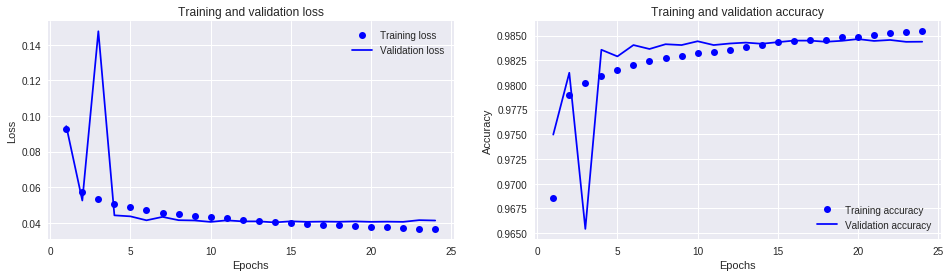

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 52s 2ms/step
([0.03905432456119455, 0.984798148978976], 0.9889694682700184)
